# COVID's Effect on Music Trend

Authors: Natnael Mekonnen, Sonya Lew, and Daniel Park

## Introduction

Last semester in spring 2019, we were hit with a COVID-19 pandemic. For the safety of our friends, family and ourselves, we all were forced to social distance, quarantine, and take our academic classes online. With online classes came a lack of face to face interaction with our classmates, TAs, and professors. Being removed from this interaction made learning and academics more challenging. A variety of challenges and tragedies like social deprivation, negative impacts on mental health, unemployment, lose of loved ones, or our health, have caused many people suffering. <br><br>
During such trying times, the three of us reflected on what helped us get through the past few months. Music came to the forefront. Many different songs entered and exited our playlists throughout the pandemic. We turned to some artists for comfort, others for energy, and many just for fun. We realized that throughout the year, though our taste in music didn't change much, the moods of songs we listened to most were diverse. <br><br>
So we wondered if this rang true for other people as well. Did our listening patterns change throughout the year? And how much of that was a result of COVID? Maybe other people are also using music to help cope with the pandemic.
We figured that this was likely true, so we set out to determine if there is a correlation to the progression of the pandemic and the songs being played with their traits (i.e. danceability, tempo, energy, etc.) to help cope with these trying times. In this exploration, we will be using these traits in correlation with COVID data to find if pandemic affected the traits of the music we listen to. 

## 1. Data Scraping

To explore the pandemic's effect on music, we chose to compare the COVID data in the US with the top 10 list on Spotify since January 2020. The reason why we chose to focus on the US is because we have more reliable, accessible, and robust data. The COVID data will be extracted from the Atlantic's [The COVID Tracking Project](https://covidtracking.com/data/national) which has been constantly updating the data everyday with representatives from 50 states, 5 territories, and District of Colombia. On the other hand, the Spotify top 10 will be extracted from the [Spotify Charts](https://spotifycharts.com/) on a weekly starting from January 2020. The charts only contain song names, artists, and a link to play each song so we will extract more info on each song by querying the Spotify API.

We imported the necessary libraries to conduct our exploratory analysis: [pandas](https://pandas.pydata.org/pandas-docs/stable/), [matplotlib](https://matplotlib.org/), [numpy](https://numpy.org/doc/), [seaborn](https://seaborn.pydata.org/) 

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf

## 1.1 Load and View COVID data

The Atlantic provides COVID data on a csv file, so we downloaded the file to our repository and store the data in a Pandas DataFrame, which allows us to manipulate the data how we want.

In [59]:
covid_data = pd.read_csv('national-history.csv')
covid_data.head()

,date,death,deathIncrease,inIcuCumulative,inIcuCurrently,hospitalizedIncrease,hospitalizedCurrently,hospitalizedCumulative,negative,negativeIncrease,onVentilatorCumulative,onVentilatorCurrently,positive,positiveIncrease,recovered,states,totalTestResults,totalTestResultsIncrease
0,12/19/2020,307831.0,2704,34949.0,21688.0,3337,113929.0,641484.0,179327206.0,1185734,3529.0,7790.0,17452905.0,201841,6882996.0,56,230325922,1725036
1,12/18/2020,305127.0,2866,34716.0,21745.0,5240,113955.0,638147.0,178141472.0,1536770,3519.0,7786.0,17251064.0,239246,6762700.0,56,228600886,2197685
2,12/17/2020,302261.0,3438,34485.0,21910.0,5133,114459.0,632907.0,176604702.0,1257526,3504.0,7847.0,17011818.0,240156,6681651.0,56,226403201,1873340
3,12/16/2020,298823.0,3448,34237.0,21946.0,4800,113278.0,627774.0,175347176.0,1200071,3488.0,7778.0,16771662.0,231653,6597661.0,56,224529861,1791968
4,12/15/2020,295375.0,2971,33958.0,21882.0,4398,112814.0,622974.0,174147105.0,1328079,3460.0,7701.0,16540009.0,189783,6490879.0,56,222737893,1781610


The COVID data is detailed but since this project is finding its relationship with music. We only care about the total number of COVID tests administered and the proportion of tests that actually were positive, so we can drop any other data from the table.

In [60]:
if 'death' in covid_data.columns:
    covid_data = covid_data.drop(['death','deathIncrease','inIcuCumulative','inIcuCurrently', 'hospitalizedIncrease','hospitalizedCurrently','hospitalizedCumulative','onVentilatorCumulative','onVentilatorCurrently','recovered','states'], axis=1)

We know that Spotify groups top 10 song data on a weekly basis starting on a Friday, so our next step is to prepare the COVID data to make this dataframe easy to merge with the Spotify dataframe. The Atlantic dataset contains daily reports on COVID statistics, so we want to group data into weeks that coincide with the Spotify data's weeks.<br>
To do this, we must create bins that denote the weekly intervals and then cut the COVID data into these bins. To be more clear, the bins specify the start and esnd dates of each week that Spotify records 

In [61]:
# Creating a custom interval index for grouping the data which starts from begining of the year 
# on a Friday and continues weekly
i = pd.to_datetime('01/10/2020')
bins = []
while i < pd.to_datetime('12/05/2020'):
    temp = i + pd.Timedelta('7 days')
    bins.append((i,temp))
    i = temp
bins = pd.IntervalIndex.from_tuples(bins) 

In [62]:
# Convert the date from the dataframe to a pandas date and time format to be comuted in the cutting
covid_data['date'] = pd.to_datetime(covid_data['date'])

# Using the interval index created above, create a new column week which has the week interval of the data
covid_data['week'] = pd.cut(covid_data['date'], bins)

# Now that every row has a week interval, they will be grouped with the total for each column 
grouped_covid = covid_data.groupby(['week']).sum()

# Number the weeks to easily identify
grouped_covid['week_num'] = list(range(1,len(bins)+1))

grouped_covid.head()

,negative,negativeIncrease,positive,positiveIncrease,totalTestResults,totalTestResultsIncrease,week_num
week,,,,,,,
"(2020-01-10, 2020-01-17]",0.0,0,0.0,0,0,0,1
"(2020-01-17, 2020-01-24]",0.0,0,10.0,2,5,2,2
"(2020-01-24, 2020-01-31]",0.0,0,14.0,0,28,6,3
"(2020-01-31, 2020-02-07]",0.0,0,23.0,3,89,8,4
"(2020-02-07, 2020-02-14]",0.0,0,38.0,2,140,6,5


In [63]:
column_names = ['week_num','positiveIncrease','negativeIncrease','positive','negative','totalTestResultsIncrease','totalTestResults']
grouped_covid = grouped_covid.reindex(columns=column_names)

grouped_covid.head()

,week_num,positiveIncrease,negativeIncrease,positive,negative,totalTestResultsIncrease,totalTestResults
week,,,,,,,
"(2020-01-10, 2020-01-17]",1,0,0,0.0,0.0,0,0
"(2020-01-17, 2020-01-24]",2,2,0,10.0,0.0,2,5
"(2020-01-24, 2020-01-31]",3,0,0,14.0,0.0,6,28
"(2020-01-31, 2020-02-07]",4,3,0,23.0,0.0,8,89
"(2020-02-07, 2020-02-14]",5,2,0,38.0,0.0,6,140


## 1.2 Load and View Spotify Top 10 Weekly Data

As mentioned above, the weekly Spotify top 10 list for each week in 2020 has been downloaded as a csv file. However, since the data is not robust with only the track name, artist, streams, and the URL as the columns, the Spotify developer API was used to get more detail information on the songs and collectively stored under [`data10.csv`](https://github.com/sonyal/COVIDSpotifyTrends/blob/main/data10.csv). The data from the API adds several more metrics to the songs including length, popularity, danceability and more. 

The script to run this process is under  [`spotify_data_extraction.py`](https://github.com/sonyal/COVIDSpotifyTrends/blob/main/spotify_data_extraction.py). It works by first extracting the csv files, pulling the song id from the URL column, calling the `getTrackFeatures` function which returns the API data for the specified song, and lastly it stores it in a common dataframe which later gets converted to a csv file. 

In [64]:
spotify_data = pd.read_csv('data.csv')
spotify_data.head()

,name,album,artist,release_date,length,popularity,danceability,acousticness,danceability.1,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature,start_date,end_date
0,The Box,Please Excuse Me For Being Antisocial,Roddy Ricch,2019-12-06,196652,90,0.896,0.1040,0.896,0.586,0.00000,0.7900,-6.687,0.0559,116.971,4,2020-01-03,2020-01-10
1,ROXANNE,ROXANNE,Arizona Zervas,2019-10-10,163636,88,0.621,0.0522,0.621,0.601,0.00000,0.4600,-5.616,0.1480,116.735,5,2020-01-03,2020-01-10
2,Yummy,Yummy,Justin Bieber,2020-01-03,210426,79,0.687,0.3660,0.687,0.514,0.00000,0.1160,-6.612,0.0897,145.921,4,2020-01-03,2020-01-10
3,Circles,Hollywood's Bleeding,Post Malone,2019-09-06,215280,90,0.695,0.1920,0.695,0.762,0.00244,0.0863,-3.497,0.0395,120.042,4,2020-01-03,2020-01-10
4,BOP,KIRK,DaBaby,2019-09-27,159714,85,0.769,0.1890,0.769,0.787,0.00000,0.1290,-3.909,0.3670,126.770,4,2020-01-03,2020-01-10


In [65]:
spotify_data['start_date']  = pd.to_datetime(spotify_data['start_date'])

# Using the same interval index created for the covid_data, create a new column week which has the week interval
spotify_data['week'] = pd.cut(spotify_data['start_date'], bins)

# Now that week is included, we can reindex with only the columns we need
spotify_data = spotify_data.reindex(columns=['week','length', 'popularity',
       'danceability', 'acousticness', 'energy', 'instrumentalness', 'liveness', 
       'loudness', 'speechiness', 'tempo', 'time_signature'])

Now that every row has a week interval, they will be grouped with the mean for each column. The following table will contain Spotify data during the pandemic.

In [66]:
grouped_spotify = spotify_data.groupby(['week']).mean()
grouped_spotify.head()

,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
week,,,,,,,,,,,
"(2020-01-10, 2020-01-17]",215694.400000,76.800000,0.736567,0.251691,0.543553,0.034003,0.202063,-7.607967,0.161413,121.679600,4.033333
"(2020-01-17, 2020-01-24]",197874.266667,79.166667,0.725900,0.249792,0.580533,0.030814,0.171410,-6.569833,0.160277,130.922133,4.033333
"(2020-01-24, 2020-01-31]",198965.700000,81.166667,0.726300,0.250979,0.565867,0.030795,0.178673,-6.502900,0.160463,128.848500,4.033333
"(2020-01-31, 2020-02-07]",192784.100000,79.600000,0.719967,0.212842,0.594967,0.022089,0.194757,-6.277200,0.137230,128.143767,4.000000
"(2020-02-07, 2020-02-14]",197652.433333,78.333333,0.733367,0.259486,0.574333,0.022342,0.167743,-6.568800,0.141607,129.174133,4.033333


## 1.3 Merge the Spotify and Covid Data

At this point both the grouped_covid data and the grouped_spotify data have been grouped with the same time interval, week. Hence, they both can be merged together makinging it easier to analyze. 

In [67]:
merged = grouped_covid.merge(grouped_spotify, left_on='week', right_on='week')[:46]
merged.tail()

,week_num,positiveIncrease,negativeIncrease,positive,negative,totalTestResultsIncrease,totalTestResults,length,popularity,danceability,acousticness,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
week,,,,,,,,,,,,,,,,,,
"(2020-10-23, 2020-10-30]",42,548531,6442855,60987944.0,8.159270e+08,8724944,1001566752,185245.733333,89.066667,0.673300,0.245777,0.594900,0.000036,0.146427,-6.677767,0.121507,120.441200,3.900000
"(2020-10-30, 2020-11-06]",43,755922,7010609,65678833.0,8.625697e+08,9554208,1064977639,188892.200000,91.833333,0.696067,0.258977,0.617433,0.000303,0.165863,-6.788200,0.123557,120.558833,3.966667
"(2020-11-06, 2020-11-13]",44,971012,7293300,71671302.0,9.129258e+08,10192332,1134487741,193855.100000,91.300000,0.690100,0.241555,0.597300,0.004369,0.133317,-6.791800,0.140933,125.320600,3.966667
"(2020-11-13, 2020-11-20]",45,1169882,8311319,79323733.0,9.680047e+08,11799518,1212343446,184234.300000,92.333333,0.689467,0.268086,0.590600,0.004340,0.155223,-7.175900,0.111603,122.797867,3.966667
"(2020-11-20, 2020-11-27]",46,1167379,8847032,87662357.0,1.030074e+09,12496773,1300019098,181267.100000,89.600000,0.661500,0.344055,0.568900,0.004360,0.175580,-7.995867,0.099927,125.403267,3.933333


## 2. Data Analysis and Visualization

For the analysis and visualization, it is imperative to find the correlations between the various song features with the COVID data. 

## 2.1 Correlation Heat Map

A correlation heat map on the merged dataframe will help visualize the columns with similar linear trends.

Text(0.5, 1.0, 'Correlation of Spotify and COVID Data')

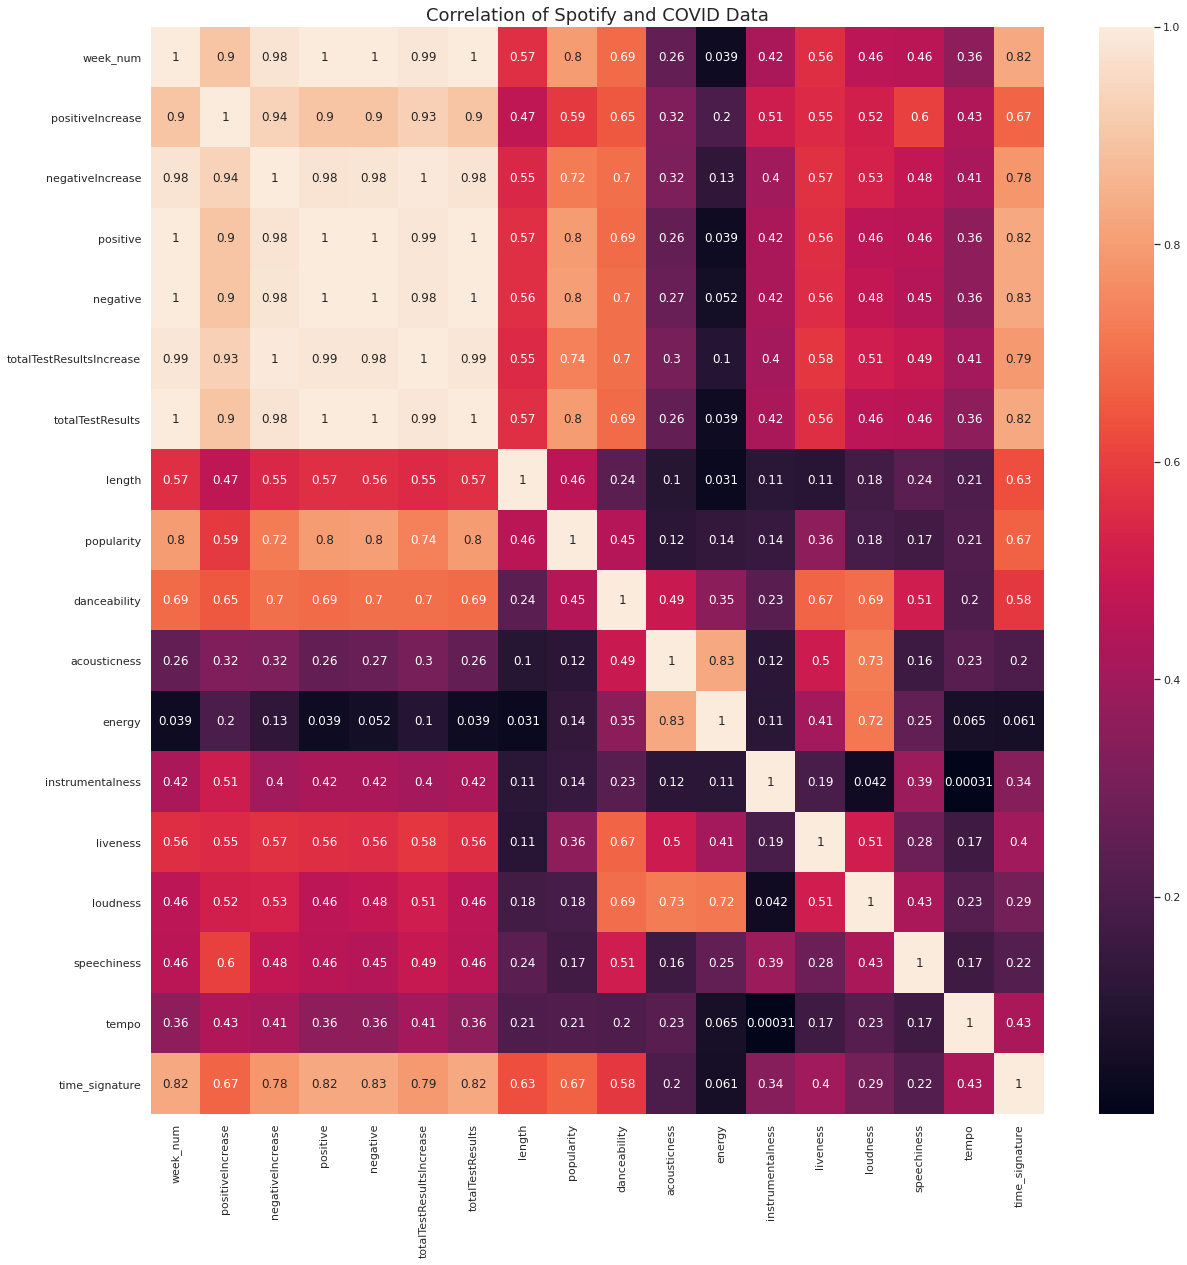

In [68]:
sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(abs(merged.corr(method="spearman")), annot=True).set_title('Correlation of Spotify and COVID Data', fontsize=18)

The above graph shows the correlation of the columns where lighter color signifies strong correlation and darker color signifies weak correlation. We can observe the strong relationships between the positive increase for COVID and danceability of the top 10 songs for the relative week. Another strong correlation we observe is that popularity of a song is correlated with the positive increase. This can be due to number of streamers increase during these times. In this project, we will further explore these correlations.

## 2.2 Danceability of Top 10 Songs vs Total Cases and Increase in Cases

In order to graph the positive increase with danceability, we have to normalize it as the danceability variable ranges from 0 to 1. In this case, min-max (rescale) normalization is used on positive increase to rescale to range from 0 to 1.

In [69]:
merged['stand_posInc'] = (merged.positiveIncrease-merged.positiveIncrease.min())/(merged.positiveIncrease.max()-merged.positiveIncrease.min())

In [70]:
# calculate slope
x = range(0, len(merged.week_num))
posInc_reg = np.polyfit(x, merged.stand_posInc, 1)
posInc_line = np.poly1d(posInc_reg)

dance_reg = np.polyfit(x, merged.danceability, 1)
dance_line = np.poly1d(dance_reg)


print(f'Slope of trend in positive test increase: {posInc_line.c[0]}')
print(f'Slope of trend in danceability of top songs: {dance_line.c[0]}')


Slope of trend in positive test increase: 0.014381765835648482
Slope of trend in danceability of top songs: -0.0018759379175660401


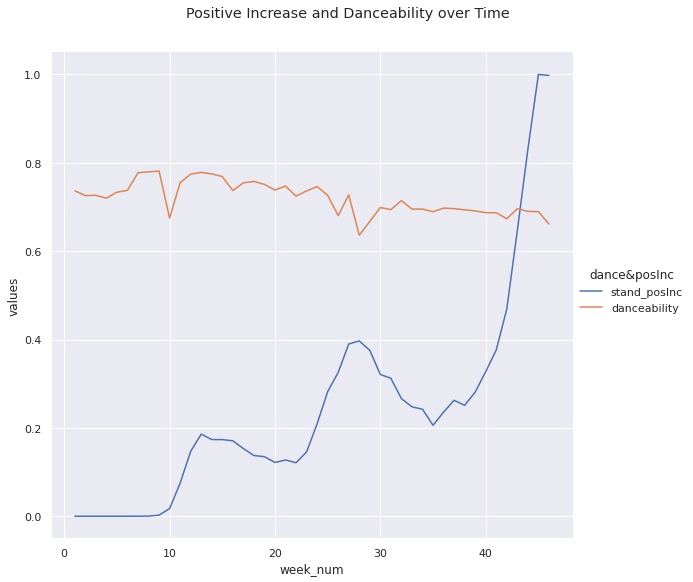

In [71]:
melted_merge = merged[['week_num', 'stand_posInc', 'danceability']]
melted_merge = melted_merge.melt('week_num', var_name='dance&posInc', value_name='values')

sns.relplot(data=melted_merge, x='week_num', y='values', hue='dance&posInc', kind='line',height=8, aspect=1).fig.suptitle('Positive Increase and Danceability over Time')

plt.subplots_adjust(top=0.9)

From the above graph, it can be seen that when the number of positve increase per week increases the danceability of the top 10 songs also decreases. More specifially around week 10 and week 28 which are both significant week when COVID spiked. Week 10 is around March when the stay at home orders were in place and week 28 is around July when everyone went outside to celebrate 4th of July. It is clear that there is a relationship between danceability with positve test increase when it spiked, but to see if in danceability is affected in general, further exploration is needed.<br>
Since popularity has a significant correlation with a positive increase in cases as well, we'll delve into its relationship in the same manner.

Slope of trend in positive test increase: 0.014381765835648482
Slope of trend in popularity of top songs: 0.29669236303833807


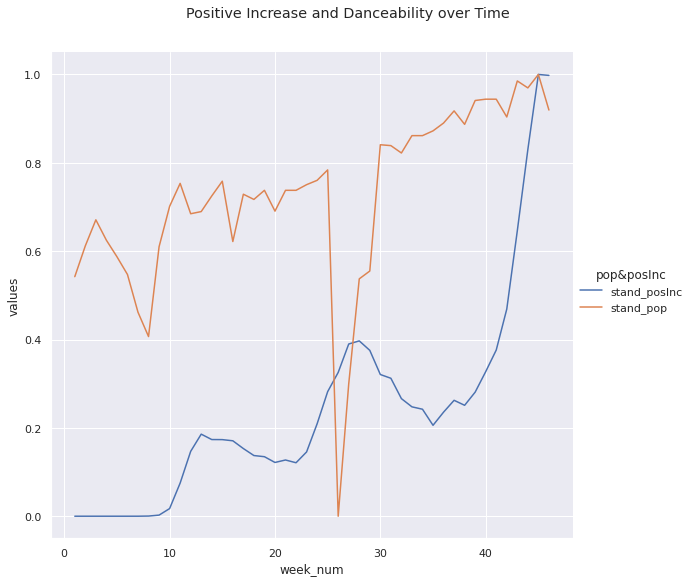

In [72]:
x = range(0, len(merged.week_num))
pop_reg = np.polyfit(x, merged.popularity, 1)
pop_line = np.poly1d(pop_reg)


print(f'Slope of trend in positive test increase: {posInc_line.c[0]}')
print(f'Slope of trend in popularity of top songs: {pop_line.c[0]}')


merged['stand_pop'] = (merged.popularity-merged.popularity.min())/(merged.popularity.max()-merged.popularity.min())

melted_merge = merged[['week_num', 'stand_posInc', 'stand_pop']]
melted_merge = melted_merge.melt('week_num', var_name='pop&posInc', value_name='values')

sns.relplot(data=melted_merge, x='week_num', y='values', hue='pop&posInc', kind='line',height=8, aspect=1).fig.suptitle('Positive Increase and Danceability over Time')
plt.subplots_adjust(top=0.9)

Somewhat similarly to danceability, peaks in increases in cases (i.e. significant dates for the COVID timeline) conincide with dips in popularity of top 10 songs. However, both popularity and increases in cases had positive slopes.

## 2.3 Pre-COVID vs. During COVID

So far, we've established that there's a significant relationship between the weekly increase in & total number of COVID cases and the danceability and popularity of Spotify's top 10 weekly songs. We can fairly conclude there is some statistical support of the idea that COVID's progression impacts the characteristics of songs that trend on Spotify. But to further explore this relationship, let's see how listening trends in 2019 and the months leading up to the pandemic compare to trends during the pandemic. <br><br>
We'll extract Spotify's Top 10 song data from 2/15/19 until 2/25/20. We define 2/25/20 as the beginning of the pandemic in the U.S. because the country saw its first positive test results during this week. <br><br>
We start by running the song info [`spotify_data_extraction`](https://github.com/sonyal/COVIDSpotifyTrends/blob/main/spotify_data_extraction.py) on the csv files that contain the top 10 Spotify songs during the mentioned timeframe. The script returns a csv file that compiles all the track info for these songs which we use to create a Dataframe.

In [73]:
pre_spotify = pd.read_csv('pre_data.csv')
pre_spotify.sort_values(by=['start_date'], inplace=True)

Then we create bins denoting the start and end date intervals of each week the Spotify songs trended.

In [74]:
# We want to analyze Spotify data from January 2019 to January 2020 to compare to Spotify data when the first tests were administered
i = pd.to_datetime('02/14/2019')
pre_bins = []
while i < pd.to_datetime('02/18/2020'):
    temp = i + pd.Timedelta('7 days')
    pre_bins.append((i,temp))
    i = temp
pre_bins = pd.IntervalIndex.from_tuples(pre_bins)


After categorizing each song by the week they trended, we average the characteristics of songs for each week.
More clearly, for each week, we find the average of the danceability, popularity, etc. of all the songs from that week and reduce the DataFrame to a weekly average table


In [75]:
pre_spotify['start_date'] = pd.to_datetime(pre_spotify['start_date'])

# Using the interval index created above, create a new column week which has the week interval of the data
pre_spotify['week'] = pd.cut(pre_spotify['start_date'], pre_bins)

# Now that every row has a week interval, they will be grouped with the total for each column 
pre_spotify = pre_spotify.groupby(['week']).mean().reset_index()

# Number the weeks to easily identify
pre_spotify['week_num'] = list(range(1,len(pre_bins)+1))
grouped_pre = pre_spotify[:52]


pre_spotify = grouped_pre.groupby(['week_num']).mean().reset_index()
pre_spotify.head()

,week_num,length,popularity,danceability,acousticness,danceability.1,energy,instrumentalness,liveness,loudness,speechiness,tempo,time_signature
0,1,193647.6,63.8,0.7991,0.25516,0.7991,0.5111,1.252100e-04,0.16664,-7.8419,0.14818,114.6845,4.0
1,2,199759.0,60.6,0.8034,0.24636,0.8034,0.5188,1.255160e-04,0.16755,-8.0770,0.14676,115.4888,4.0
2,3,197647.5,58.8,0.7705,0.26578,0.7705,0.5289,5.160000e-07,0.15575,-7.1664,0.12022,113.8648,4.0
3,4,196878.2,69.9,0.7732,0.27028,0.7732,0.5513,5.160000e-07,0.13624,-7.1182,0.12163,120.7803,4.1
4,5,194975.1,70.2,0.7690,0.22921,0.7690,0.5567,5.160000e-07,0.13684,-7.0484,0.14759,121.5846,4.1


How do the trends in danceability and popularity of top Spotify songs compare to these trends pre-COVID?
Let's find out. Let's talk about danceability first. We create a relational plot that compares the danceability of top 10 songs throughout February 2019 to February 2020 to those throughout the pandemic this year.

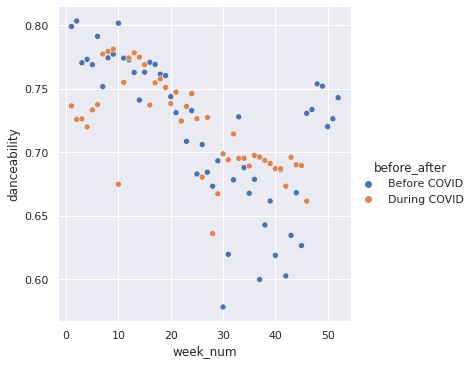

In [76]:
grouped_spotify['week_num'] = list(range(1,len(grouped_spotify)+1))

temp1 = grouped_pre
temp2 = grouped_spotify
temp1["before_after"] = np.array("Before COVID")
temp2["before_after"] = np.array("During COVID")

all_spotify = temp1.append(temp2)

sns.relplot(y="danceability", x="week_num", hue="before_after", data=all_spotify)

Danceability of top 10 Spotify songs pre-COVID are shown in blue and those during the pandemic are shown in orange.
There appears to be a more noticeable decline in danceability of top 10 songs as the year before the pandemic progressed compared to that of trending songs during the pandemic. 

For a more concrete understanding of their differences, let's look at their regressions. <br><br>
Below, we plot the danceability of songs before pre-COVID and during COVID on separate graphs and draw regression lines for both. <br>
Seaborn's `lmplot` plots the data points and draws the regression line, but it doesn't report the actual equation of the line. But numpy allows us to calculate it ourselves. 

Top 10 songs on Spotify pre-COVID:
	Slope of trend of danceability: -0.0023888329206864165
	Standard deviation of danceability: 0.058234490358120124

Top 10 songs on Spotify during COVID:
	Slope of trend in danceability: nan
	Standard deviation of danceability: 0.036512539011951804


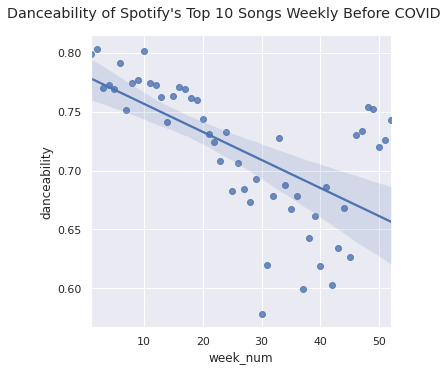

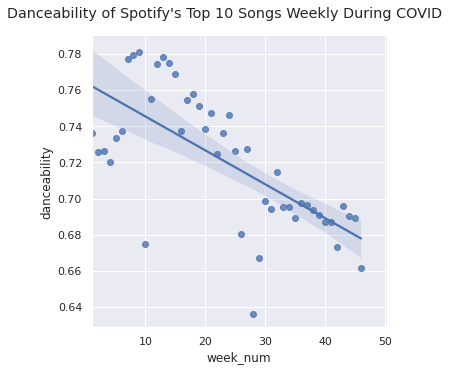

In [77]:
fig = sns.lmplot(y="danceability", x="week_num", data=pre_spotify);
fig = fig.fig
fig.suptitle("Danceability of Spotify's Top 10 Songs Weekly Before COVID")
fig.subplots_adjust(top=0.9)

fig = sns.lmplot(y="danceability", x="week_num", data=grouped_spotify);
fig = fig.fig
fig.suptitle("Danceability of Spotify's Top 10 Songs Weekly During COVID")
fig.subplots_adjust(top=0.9)

x = range(0, len(pre_spotify.week_num))
pre_reg = np.polyfit(x, pre_spotify.danceability, 1)
pre_line = np.poly1d(pre_reg)

x = range(0, len(grouped_spotify.week_num))
during_reg = np.polyfit(x, grouped_spotify.danceability, 1)
during_line = np.poly1d(during_reg)


print('Top 10 songs on Spotify pre-COVID:')
print(f'\tSlope of trend of danceability: {pre_line.c[0]}\n\tStandard deviation of danceability: {pre_spotify.danceability.std()}\n')

print('Top 10 songs on Spotify during COVID:')
print(f'\tSlope of trend in danceability: {during_line.c[0]}\n\tStandard deviation of danceability: {grouped_spotify.danceability.std()}')


The regression lines confirm our suspicions: the danceability of top 10 songs before COVID more rapidly declined as the weeks progressed compared to during COVID. We can see that it increased right before the start of the pandemic, but in general the slope of the regression was negative. <br>
The slope of the regression for danceability during COVID also declined, albeit less rapidly. However, danceability during this time period fluctuated a bit. We know that this fluctuation coincided with fluctuations in total number of and increases in COVID cases nationally. Although the general trend of danceability during COVID was negative, danceability during this time was more spread. The standard deviation of danceability during COVID is higher than it is before COVID.<br>
These findings support the correlation we found between COVID and danceability in the previous section. It seems something different (i.e. COVID) is affecting listening trends this year! Let's see if this holds true for top 10 songs' popularity as well.

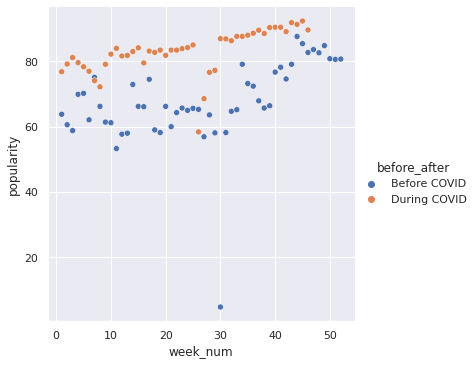

In [78]:
sns.relplot(y="popularity", x="week_num", hue="before_after", data=all_spotify)

It looks like for most weeks this year, the top 10 songs are more popular than songs from the same weeks a year before. 

Top 10 songs on Spotify pre-COVID:
	Slope of trend of popularity: 0.3894262784939809
	Standard deviation of popularity: 12.617436730695028

Top 10 songs on Spotify during COVID:
	Slope of trend in popularity: nan
	Standard deviation of popularity: 6.572372436324694


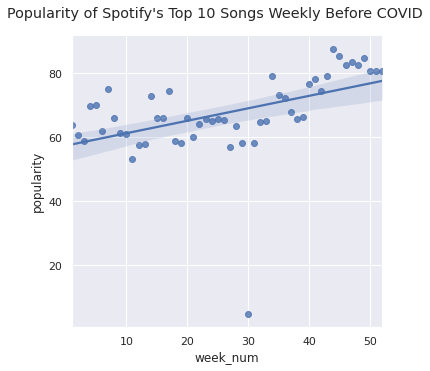

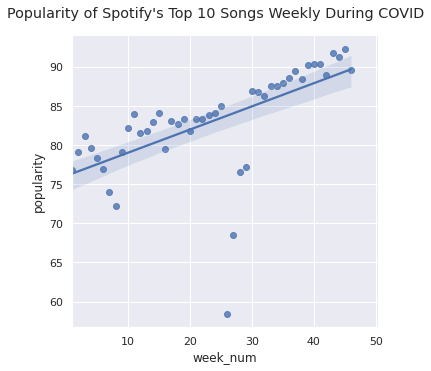

In [79]:
fig = sns.lmplot(y="popularity", x="week_num", data=pre_spotify);
fig = fig.fig
fig.suptitle("Popularity of Spotify's Top 10 Songs Weekly Before COVID")
fig.subplots_adjust(top=0.9)

fig = sns.lmplot(y="popularity", x="week_num", data=grouped_spotify);
fig = fig.fig
fig.suptitle("Popularity of Spotify's Top 10 Songs Weekly During COVID")
fig.subplots_adjust(top=0.9)

x = range(0, len(pre_spotify.week_num))
pre_reg = np.polyfit(x, pre_spotify.popularity, 1)
pre_line = np.poly1d(pre_reg)

x = range(0, len(grouped_spotify.week_num))
during_reg = np.polyfit(x, grouped_spotify.popularity, 1)
during_line = np.poly1d(during_reg)


print('Top 10 songs on Spotify pre-COVID:')
print(f'\tSlope of trend of popularity: {pre_line.c[0]}\n\tStandard deviation of popularity: {pre_spotify.popularity.std()}\n')

print('Top 10 songs on Spotify during COVID:')
print(f'\tSlope of trend in popularity: {during_line.c[0]}\n\tStandard deviation of popularity: {grouped_spotify.popularity.std()}')


For popularity, there was less of a difference in the slopes of regression lines. Both slopes slightly increased but the standard deviation for popularity during COVID was higher than before COVID. The data that falls farther from the regression during COVID aligns with the weeks in which increases in positive cases peaked.

In [85]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

## 3. Predicting Trends Future Trends

To recap, we've established a relationship between positive increases in and total number of COVID cases vs. danceability and popularity of the top 10 songs on Spotify weekly based on their correlation coefficients, distributions, and regression lines. The strength of their correlation indicates a predictive relationship between the increase in number of positive cases and the danceability and popularity of these songs.

So let's predict how these trends will continue as the pandemic progresses.


We'll use sklearn to conduct our machine learning regression algorithm. Since the relationships are linear and don't involve classification, we will use a linear regression model to perform predictive analyis. We utilize sklearn's `train_test_splot()` function to split the data into training and testing sets. The training data, as its name suggests, is used to train the model to create a linear regression to predict danceability of top 10 songs depending on the postiive increase in and total number of COVID cases. The linear regression prediction is graphed along with the testing set regression. The testing set regression was the data set aside to test the accuracy of the prediction.

<AxesSubplot:xlabel='danceability', ylabel='Density'>

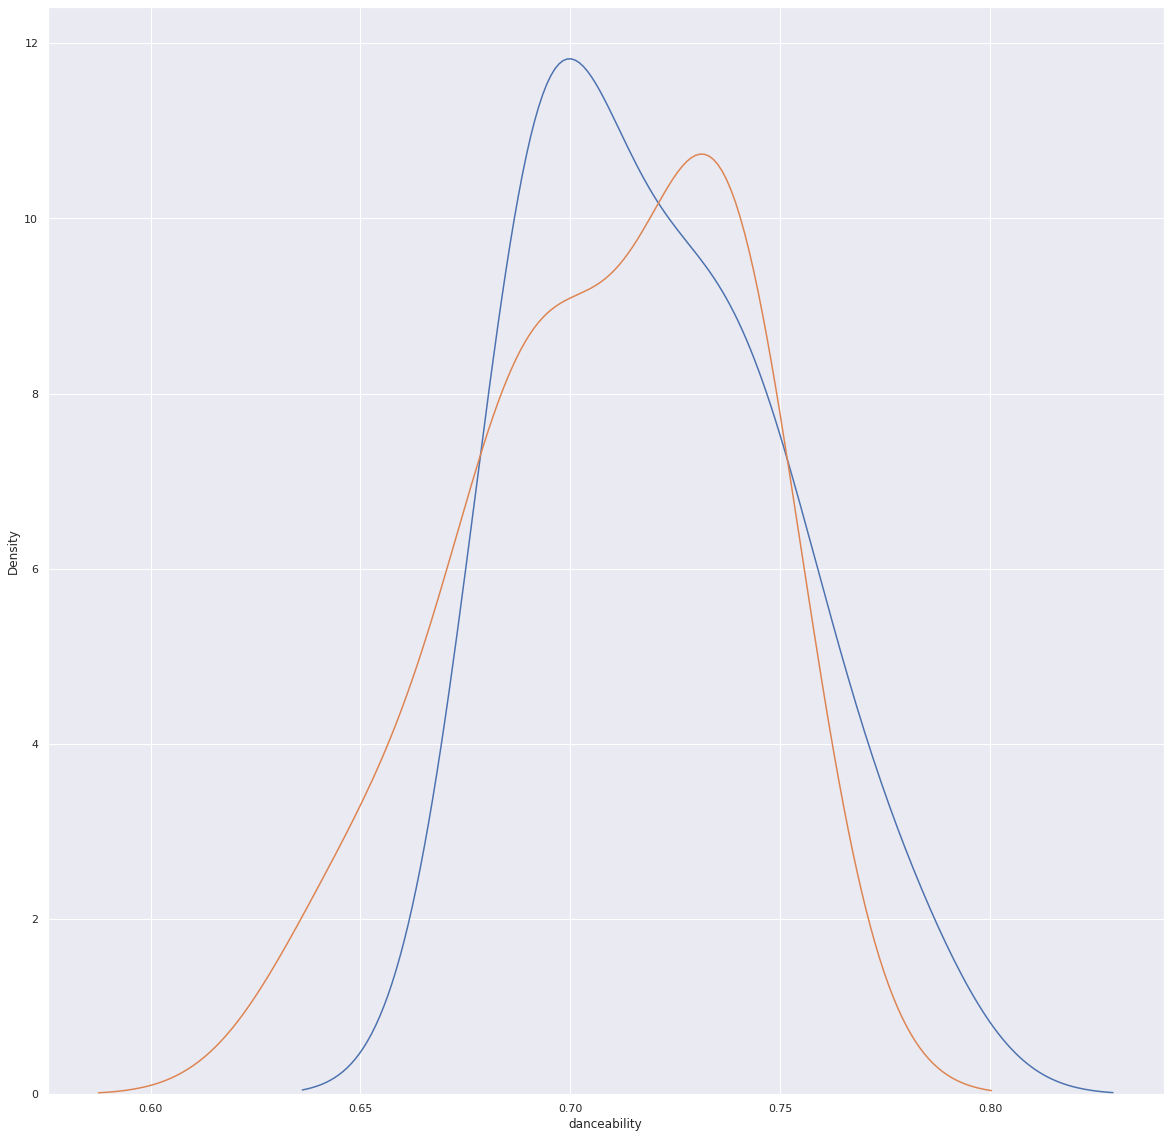

In [81]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn import model_selection

X = grouped_covid.reset_index()[['positive', 'positiveIncrease']]
y = grouped_spotify[:48].danceability

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.3)
X_train['dance'] = y_train.values


lr = smf.ols(formula='dance ~ positive + positiveIncrease', data=X_train).fit()
preds_lr = lr.predict(X_test)

f, ax = plt.subplots()
sns.distplot(y_test, hist=False, label="Actual", ax=ax)
sns.distplot(preds_lr, hist=False, label="Linear Regression Predictions", ax=ax)

Visually, the prediction somewhat aligns with the actual data, but its highest peak rises much higher than the actual testing set's. To more empirically test the prediction's validity, we use statistical analysis.

In [82]:
from scipy.stats import f as ft

# F-Test to evaluate goodness of fit
print(lr.params)
test = lr.f_test(np.identity(len(lr.params)))
print(' Model - Calculated F-Statistic: ' + str(ft.ppf(.95,test.df_num,test.df_denom)) + \
    ' F-Value: ' + str(test.fvalue[0][0]) + ' P-Value: ' + str(test.pvalue))

Intercept           7.450050e-01
positive           -1.192592e-09
positiveIncrease    9.644069e-09
dtype: float64
 Model - Calculated F-Statistic: 3.327654498572059 F-Value: 5468.23747433397 P-Value: 4.210881182213785e-38
/home/codespace/workspace/COVIDSpotifyTrends/pythonenv3.8/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '


The F-Values are greater than the F-Statistics and the p-value is < 0.05. This supports that the predicted model is significant.<br><br>
We go on to do the same for top 10 Spotify song popularity vs increase in and total COVID cases.

<AxesSubplot:xlabel='popularity', ylabel='Density'>

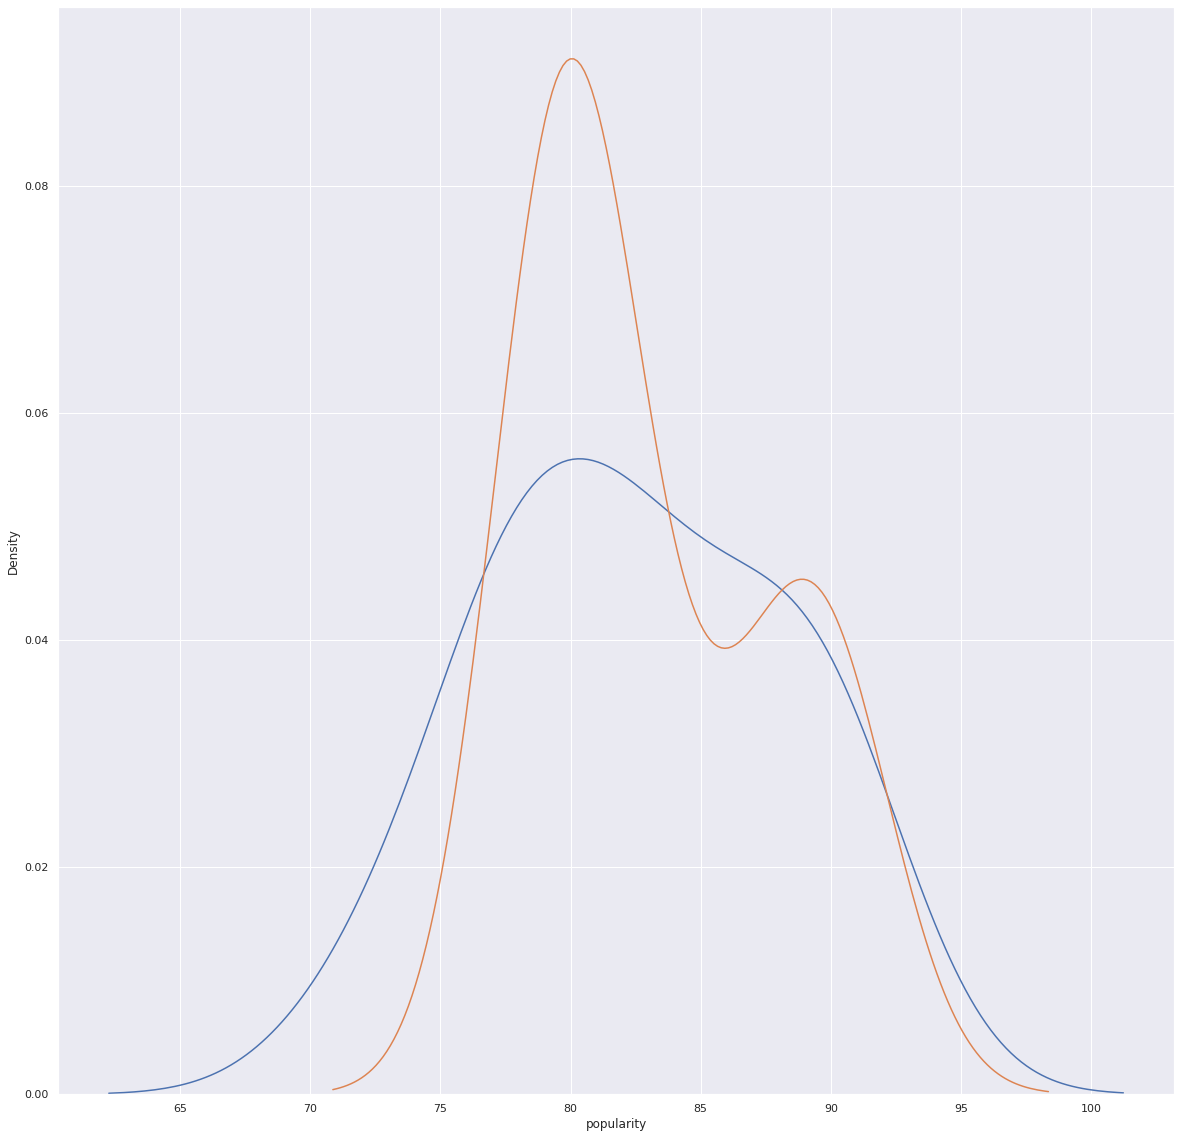

In [83]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

X = grouped_covid.reset_index()[['positive', 'positiveIncrease']]
y = grouped_spotify['popularity']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=.3)
X_train['pop'] = y_train.values

lr = smf.ols(formula='pop ~ positive + positiveIncrease', data=X_train).fit()
preds_lr = lr.predict(X_test)

f, ax = plt.subplots()
sns.distplot(y_test, hist=False, label="Actual", ax=ax)
sns.distplot(preds_lr, hist=False, label="Linear Regression Predictions", ax=ax)

The predicted regression is even more closely similar to the actual testing data's regression which is a good sign.

In [84]:
# F-Test to evaluate goodness of fit

test = lr.f_test(np.identity(len(lr.params)))
print(' Model - Calculated F-Statistic: ' + str(ft.ppf(.95,test.df_num,test.df_denom)) + \
    ' F-Value: ' + str(test.fvalue[0][0]) + ' P-Value: ' + str(test.pvalue))

 Model - Calculated F-Statistic: 3.340385558237759 F-Value: 1435.646218397193 P-Value: 6.139374443389862e-29
/home/codespace/workspace/COVIDSpotifyTrends/pythonenv3.8/lib/python3.8/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  warnings.warn('covariance of constraints does not have full '


Again, the F-Value is greater than the F-Statistic and the p-value is < 0.05, so this model for predicting the popularity of trending songs on Spotify using total and increase in COVID cases as predictors is statistically significant.


# Conclusion

After comparing the COVID data and the spotify data we were able to find a correlation between the current status of the pandemic and spotify listening trends, specifically the rate at which people are catching covid and the total number of case, danceability, populatiry of the top 10 songs on spotify. Based on this, we were able to create a formula to predict how these listening trends will continue until the end of the pandemic. These findings can be connected in other studies to other variables to understand how people use music to cope with stressful events.